In [1]:
import os
import pandas as pd
import re
import numpy as np
import time
import collections
from operator import itemgetter
import pprint as pp
import re
from nltk.corpus import stopwords
import nltk.data
import networkx as nx
import proj_base
from gensim.models import word2vec
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
data = proj_base.getBlankFrame()
data = proj_base.addFileToData('./Review_Texts/hotel_100504.dat', data, ) 
#data = proj_base.addFileToData('./Review_Texts/hotel_72572.dat', data) 


In [3]:
nodes = data.shape[0]
print(nodes)
data.head()
#len(set(data["Author"]))

124


,Rooms,Date,Location,Service,Business service,Author,Check in / front desk,No. Helpful,Cleanliness,Content,Value,No. Reader,Overall
0,5.0,"Dec 23, 2008",5.0,5.0,NaN,selizabethm,5.0,NaN,5.0,wonderful time- even with the snow! what a gre...,4.0,NaN,5.0
1,4.0,"Nov 13, 2008",5.0,5.0,NaN,IndieLady,5.0,NaN,4.0,"lovely hotel, unique decor, friendly front des...",5.0,NaN,4.0
2,4.0,"Nov 11, 2008",3.0,NaN,4,Hilobb,5.0,NaN,4.0,"nice hotel, expensive parking we got a good de...",4.0,NaN,4.0
3,5.0,"Nov 4, 2008",5.0,5.0,5,Chianti_girl24,5.0,NaN,5.0,fabulous hotel location and service are great....,5.0,NaN,5.0
4,NaN,"Oct 18, 2008",NaN,NaN,NaN,hothearted,NaN,2,NaN,"loved the monaco! staff was amazing, with a sm...",NaN,2,5.0


In [ ]:
data.loc[15]["Rooms"]

In [9]:
#GET HARD TRUTH RATINGS

aspect="Rooms"

In [4]:

def buildGraph(data, sim):
    
    G = nx.Graph()
    neighborsForNodes = 6
    nodes = data.shape[0]
    # build nodes
    for i in range(nodes):
        rev = data.loc[i]
        G.add_node(i, author = rev["Author"])
        
        #if i has a hard-truth rating add a node with that dongle
        if rev[aspect] != np.nan:
            G.add_node(i+nodes, truth=True, rating=rev[aspect])
            G.add_edge(i, i+nodes, weight=1)
    
    # build edges
    sims = buildSimilarityMatrix(data)
    for i in range(nodes):
        for j in range(nodes):
            G.add_edge(i, j, weight=sims[i][j])
    
    

    # add separate learner scores
    
    return G




In [7]:

def howSimilar(r1, r2):
    #use word2vec cosine similarity
    return 1.0

def buildSimilarityMatrix(data):
    
    similar = [[0]*nodes for i in range(nodes)]
    
    for i in range(nodes):
        dati = data.loc[i]["Content"]
        for j in range(nodes):
            if i != j:
                
                similar[i][j] = howSimilar(dati, data.loc[j]["Content"])
                
    return similar


def getRatings(graph):
    #minimize loss ratings over the graph
    
    
    #for edge in graph
    #   loss = 
    return

similarities = buildSimilarityMatrix(data)
#similarities





In [10]:
g = buildGraph(data, similarities)

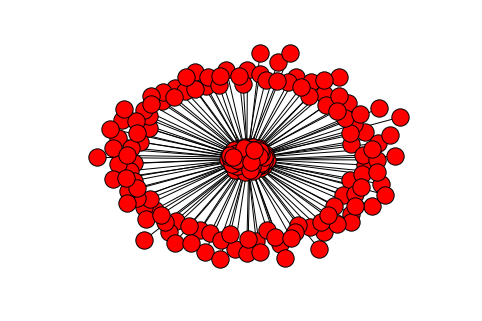

In [12]:
%matplotlib inline
nx.draw(g)
plt.show()

In [13]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


In [16]:

def review2sentences(review, tokenizer, remove_stopwords=True):
    #split each review into sentences
    raw_sent = tokenizer.tokenize(review.strip())
    
    sentences = []
    for s in raw_sent:
        if len(s) > 0 :
            sentences.append(review2wordlist(s, remove_stopwords))
            
    return sentences


def review2wordlist(review_text, remove_stopwords=True):
    #split each sentence into BOW
    

    review_text = re.sub("[^a-zA-Z]"," ", review_text)

    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return(words)


In [ ]:
from bs4 import BeautifulSoup

In [17]:


sentences = []

#word2vec takes a list of lists, where each internal list is a BOW

for review in data["Content"]:
    sentences += review2sentences(review, tokenizer)
    
    


In [18]:
sentences[0:3]

[['wonderful', 'time', 'even', 'snow'],
 ['great', 'experience'],
 ['goldfish',
  'room',
  'daughter',
  'loved',
  'fact',
  'valet',
  'parking',
  'staff',
  'put',
  'chains',
  'fabulous']]

In [ ]:
num_features = 200
min_word_count = 40
num_workers = 2
context = 2
downsampling = 1e-3

from gensim.models import word2vec
print("training")
model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features)

def makeFeatureVec(words, model, num_features):
    
    featureVec = np.zeros((num_features,), dtype="float32")
    
    nwords = 0
    index2word_set = set(model.index2word)
    
    
    #get the mean vector for each review
    for w in words:
        if w in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec, model[w])
            
    featureVec = np.divide(featureVec, nwords)
    return featureVec

def getAvgFeatureVecs(reviews, model, num_features):
    #get average feature vec for review
    count = 0
    reviewFeatureVec = np.zeros((len(reviews), num_features), dtype="float32")
    
    for r in reviews:
        if count % 1000 == 0:
            print("at review", count)
        #for each review add the feature vec
        reviewFeatureVec[count] = makeFeatureVec(r, model, num_features)
        count += 1
        
    return reviewFeatureVec

In [ ]:
#from sklearn.svm import SVC

#do svm classification
#need to split data into hard-truth train and predict
#not sure how were actually going to do this. Hard-truth ratings are needed to train the model right?
#but we'll also need to have some to test the results
#so probably going to need to have a lot of reviews

#train = sample of data with hard rating

trainDataVecs = getAvgFeatureVecs(train, model, num_features)
